# 训练及测试
本笔记本将调用hw1/hw2以作出训练结果，亦可直接导出训练代码供使用。

首先，引入必要的依赖。

In [1]:
import cv2, matplotlib, scipy.ndimage
import numpy as np
import numpy.linalg as npMat
import matplotlib.pyplot as plt

import sys, os, time

import hw1, hw2

In [2]:
datasetConfig = {1: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10,
    11: 10, 12: 10, 13: 10, 15: 10, 16: 10, 17: 10, 18: 10, 22: 10, 23: 10,
    24: 10, 25: 10, 26: 10, 27: 10}

def read_from_dataset(hw1Var = 1, hw2Var = 1) -> list:
    '''This function implements read process, and process data with colorspace transform and filter.

    hw1Var 0=rgb, 1=weighted_mean_grey, 2=mean_grey, 3=max_grey

    hw2Var 0=no_change, 1=median_filter, 2=mean_filter(3*3), 3=gaussian_filter(3*3, 1.5)

    ret list(np.array)

    in case of 
    '''
    imReturn = []
    imShapeReturn = []
    for i, jlim in datasetConfig.items():
        imAll = None
        for j in range(1, jlim + 1):
            try:
                imFile = './dataset/s{}/s{}_{}.jpg'.format(i, i, j)
                imMatrix = cv2.imread(imFile)
                imMatrix = hw1.colorSpaceMatrix(BGR = imMatrix).space[hw1Var] # default: Convert to Grey with weighted mean.
                imMatrix = hw2.hw2Config[hw2Var](imMatrix) # default: With the process of Median Filter
                imMatrix = hw2.hw2Config[hw2Var](imMatrix) # default: With the process of Median Filter
                if isinstance(imAll, np.ndarray):
                    try:
                        imAll = np.append(imAll, [imMatrix], axis=0)
                    except ValueError:
                        print("[INFO] Append Error when i = {}, j = {}.".format(i, j)) # e.g.image's height and width isn't identical to the first one.
                else:
                    imAll = np.array([imMatrix])
            except Exception as e:
                print("[INFO] {} Error when i = {}, j = {}".format(e, i, j))
        # TIP not implemented in matlab
        imShapeReturn.append([imAll.shape[1], imAll.shape[2]])
        imAll.resize((imAll.shape[0], imAll.shape[1] * imAll.shape[2])) # shrink dimension, see doc for reasons
        imReturn.append(imAll)
    return imReturn, imShapeReturn

In [3]:
%timeit read_from_dataset()
im, imShape = read_from_dataset()
print(imShape)

34.5 s ± 1.16 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
[[600, 400], [600, 400], [600, 400], [600, 400], [600, 400], [600, 400], [600, 400], [600, 400], [600, 400], [600, 400], [600, 400], [600, 400], [600, 400], [600, 400], [600, 400], [600, 400], [600, 400], [600, 400], [600, 400], [600, 400], [600, 400], [600, 400]]


## 降维

PCA 的核心步骤：计算主成分（特征值更大的特征向量），然后通过矩阵相乘 $P \cdot A$ 得 $Q$ 。

其中阐述原理：方便你的方差计算、协方差计算，so作中心化 / 零均值化。注意不是归一化。

补充分析：主成分贡献率TODO

配图：特征向量即可。但第一个特征向量似乎有点特殊。

因为数据规模过大，无法通过数据验证，由优化算法得出来的特征向量与真实特征向量组的差距。

数据规模过大的实证：如果不对临时变量作`del`处理，瞬时内存占用也会爆 2G。

目前基于 https://www.cnblogs.com/mickeyyang/p/13262472.html (SVD分解优化) 实现。

[(10, 240000), 600, 400]: [6.94224034e+09 1.29487554e+09 4.28512123e+08 5.72553170e+06
 2.98130121e+08 6.80454259e+07 2.31004526e+08 1.97541882e+08
 1.41320535e+08 1.32635171e+08]
[(10, 240000), 600, 400]: [4.53383497e+09 6.55943639e+08 3.39547954e+08 2.84478655e+08
 1.59306574e+08 4.52322993e+07 1.03197470e+08 7.15665004e+07
 8.06434696e+07 8.70317811e+07]
[(10, 240000), 600, 400]: [9.41348397e+09 3.09633492e+09 1.58506603e+09 1.13947755e+09
 6.71066987e+08 6.79868588e+08 2.85942578e+08 4.89160513e+08
 4.06484328e+08 3.54830077e+08]
[(10, 240000), 600, 400]: [5.83647843e+09 6.37749160e+08 2.79130788e+08 2.60609223e+08
 1.50829651e+08 5.90767291e+07 6.62450452e+07 8.89276389e+07
 9.83401114e+07 1.17113777e+08]
[(10, 240000), 600, 400]: [9.68119886e+09 7.79937004e+08 5.20348031e+08 3.00168422e+08
 2.84620348e+08 2.20407790e+08 1.73219662e+08 1.10115085e+08
 6.12943184e+07 7.31494380e+07]


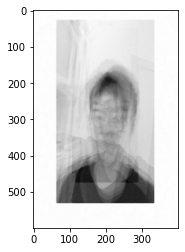

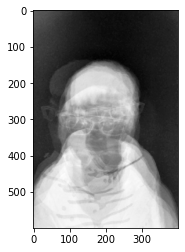

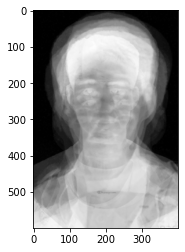

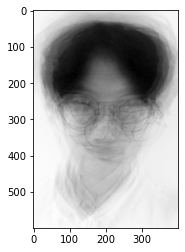

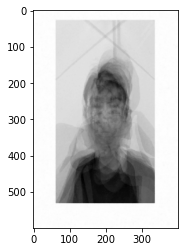

<Figure size 432x288 with 0 Axes>

In [4]:
def pca(imageFeature) -> np.ndarray:
    matMean = imageFeature - np.tile(imageFeature.mean(1), (imageFeature.shape[1], 1)).T # TIP not implemented in matlab
    # matOne = imageFeature / np.linalg.norm(imageFeature.mean(1), axis = 0) # not normalized
    # matMean = matMean.astype(np.uint8)
    # matCovaiance = np.dot(matMean.T, matMean) # still too large to calculate
    # only after zero-mean.
    eigValue, eigPreVector = npMat.eig(np.dot(matMean, matMean.T)) # already sorted by eigValue, already normalization.
    eigVector = np.dot(matMean.T, eigPreVector) / eigValue
    del matMean, eigPreVector
    eigNormalizedVector = eigVector / npMat.norm(eigVector, axis = 0)
    del eigVector
    # print(matMean, eigValue, eigPreVector, eigVector)
    processMat = np.dot(imageFeature, eigNormalizedVector)
    return eigValue, eigNormalizedVector, processMat

# As a pre dataset test
def pretest():
    for i in [8, 10, 11, 12, 15]:
        print(str([im[i].shape] + imShape[i]) + ": ", end='')
        eigValue, eigNormalizedVector, processMatrix = pca(im[i])
        print(eigValue)
        temp = (eigNormalizedVector[:, 0]).reshape((imShape[i][0], imShape[i][1]))
        plt.imshow(temp, cmap = plt.get_cmap('Greys'))
        plt.figure()
pretest()
del pretest

In [5]:
try:
    imageFeature = np.reshape(im, (len(im) * im[0].shape[0], im[0].shape[1]))
    del im
except NameError:
    pass
%timeit pca(imageFeature)
eigValue, eigNormalizedVector, processMatrix = pca(imageFeature)
print(eigValue)

14.6 s ± 1.55 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
[ 7.01300573e+10  2.61975679e+10  1.89188066e+10  1.15166267e+10
  8.80516086e+09  6.41059423e+09  4.77600051e+09  4.29238283e+09
  3.85906936e+09  3.02497473e+09  2.76680384e+09  2.65036404e+09
  2.46742358e+09  2.07197408e+09  1.82361860e+09  1.72778003e+09
  1.64363599e+09  1.50460167e+09  1.40626649e+09  1.27352247e+09
  1.21964372e+09  1.13576920e+09  1.20490714e+09  1.05231080e+09
  9.46775700e+08  9.31276824e+08  9.00411477e+08  8.67587795e+08
  8.30230910e+08  7.78585553e+08  7.17225372e+08  6.77960371e+08
  6.57481942e+08  6.45519231e+08  6.24286391e+08  5.79558537e+08
  5.75685303e+08  5.63851229e+08  5.54397441e+08  5.29506349e+08
  5.08252564e+08  4.93935165e+08  4.58449214e+08  4.49737083e+08
  4.46069824e+08  4.26644037e+08  4.16539986e+08  4.08653803e+08
  3.95716079e+08  3.81720952e+08  3.66520864e+08  3.53917279e+08
  3.53399526e+08  3.41927342e+08  3.34378447e+08  3.21778008e+08
  3.17374144e+08  3.147

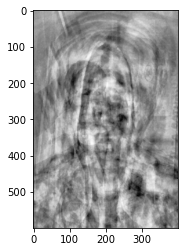

In [6]:
np.savez("train.npz", eVal = eigValue, eNorVec = eigNormalizedVector, pMat = processMatrix, utils = 
    [[idPack[0], 10 * (count0 + 1), imShape[0][0], imShape[0][1]] for count0, idPack in enumerate(datasetConfig.items())]
    )
temp = (eigNormalizedVector[:, 60]).reshape((imShape[0][0], imShape[0][1]))
plt.imshow(temp, cmap = plt.get_cmap('Greys'))